In [1]:
# region imports
import os
import sys
import math
from abc import ABC
import copy

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as TVDatasets

import torch_geometric
from torch_geometric.data import Data as GraphData
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models.label_prop import LabelPropagation
import torch_geometric.datasets as pyg_datasets
from torch_geometric.utils import to_networkx

import seaborn as sns
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from tqdm.notebook import tqdm

import sys
# endregion

# region local imports (anonymize!)
sys.path.append('./packages/TorchGNN-Utils')
from tgnnu.data_utils.splits import SplitManager
from tgnnu.networks.node_classif_models import GCN, GAT, APPNPNet, SAGE, MLP
from tgnnu.networks.node_classif_lightner import NodeLevelGNN

sys.path.append("./packages/cp-in-graph-homophily")
import gnn_cp.cp.transformations as cp_t
import gnn_cp.cp.graph_transformations as cp_gt
from gnn_cp.cp.graph_cp import GraphCP
# endregion

from graph_split import GraphSplit
import utils

# Argparser: uncomment for singlton python file, then comment the part below
# import argparse
# parser = argparse.ArgumentParser(description="Runs the node-exch setting for 1 calibration sampling.")
# parser.add_argument("--dataset", type=str, default="cora_ml", help="The desired dataset")
# parser.add_argument("--model", type=str, default="GCN", help="The desired model")
# parser.add_argument("--method", type=str, default="APS", help="Conformal score function")
# parser.add_argument("--trbudget", type=int, default=20, help="The budget for training (per class)")
# parser.add_argument("--minibatch", type=int, default=1, help="The number of nodes arriving at each sequence step")

# args = parser.parse_args()

# default Argparser for ipykernel. Comment it on singleton python file. 
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
args = AttrDict()
args["dataset"] = "citeseer"
args["model"] = "GCN"
args["method"] = "APS"
args["trbudget"] = 20
args["minibatch"] = 1


dataset_key = args.dataset
model_key = args.model

stratif_train_budget = args.trbudget
mini_batch_size = args.minibatch

if dataset_key in ["cora_ml", "pubmed", "citeseer"]:
    dataset = pyg_datasets.CitationFull(root="../data-cache/", name=dataset_key).data.to(device)
if dataset_key in ["Coauth-CS", "Coauth-Physics"]:
    dataset = pyg_datasets.Coauthor(root="../data-cache/", name=dataset_key.replace("Coauth-", "")).data.to(device)
if dataset_key in ["Amz-Computers", "Amz-Photo"]:
    dataset = pyg_datasets.Amazon(root="../data-cache/", name=dataset_key.replace("Amz-", "")).data.to(device)

# Baseline Parameters

if model_key == "GCN":
    model_params = {
        "n_features": dataset.x.shape[1], 
        "n_hidden": 64, 
        "n_classes": dataset.y.max().item() + 1, 
        "p_dropout": 0.6
    }
    optimizer_params = {"weight_decay": 1e-2}

    model_r = GCN(**model_params)

elif model_key == "GAT":
    model_params = {
        "n_features": dataset.x.shape[1], 
        "n_classes": dataset.y.max().item() + 1, 
        "n_hidden": 64,
        "n_heads": 8,
        "p_dropout": 0.6,
    }
    optimizer_params = {"lr": 0.01, "weight_decay": 0.01}
    
    model_r = GAT(**model_params)

elif model_key == "SAGE":
    model_params = {
        "n_features": dataset.x.shape[1], 
        "n_classes": dataset.y.max().item() + 1, 
        "n_hidden": 32,
        "p_dropout": 0.4,
    }
    optimizer_params = {
        "lr": 0.0005,
        "weight_decay": 0.05}
    model_r = SAGE(**model_params)

elif model_key == "MLP":
    model_params = {
        "n_features": dataset.x.shape[1], 
        "n_classes": dataset.y.max().item() + 1, 
        "n_hidden": 64,
        "p_dropout": 0.8
    }
    optimizer_params = {
        "lr": 0.005,
        "weight_decay": 0.01,
    }
    model_r = MLP(**model_params)

elif model_key == "APPNPNet":
    model_params = {
        "n_features": dataset.x.shape[1], 
        "n_classes": dataset.y.max().item() + 1, 
        "n_hidden": 64,
        "p_dropout": 0.5,
        "alpha": 0.1,
        "k_hops": 10
    }
    optimizer_params = {
        "lr": 0.01,
        "weight_decay": 0.0001,
    }
    model_r = APPNPNet(**model_params)

model = NodeLevelGNN(model_r)
model.set_optimizer(optimizer_keyargs=optimizer_params)


training_budget = stratif_train_budget
calibration_budget = training_budget * (dataset.y.max().item() + 1)


main_split = GraphSplit.from_dataset(dataset)
training_mask = main_split.sample_nodes(training_budget, stratified=True)
validation_mask = main_split.sample_nodes(training_budget, stratified=True)
test_mask = ~(training_mask | validation_mask)

labeled_mask = (training_mask | validation_mask)
training_subgraph = utils.node_induced_subgraph(dataset, labeled_mask)
model.fit(training_subgraph, epochs=1000, train_mask=training_mask, val_mask=validation_mask, patience=100)
acc = model.evaluate(dataset, dataset.y, test_mask)
print(f"Model trained - acc = {acc}")

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch Graph Models are running on cuda
Torch Graph Models are running on cuda
v16


/opt/conda/lib/python3.8/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Model trained - acc = 0.8055137991905212


In [2]:
dataset.x.shape

torch.Size([4230, 602])

In [3]:
## Methods
# singleton hits measure for conformal prediction
def singleton_hit(pred_set, true_mask):
    one_sized_pred = (pred_set.sum(axis=1) == 1)
    result = pred_set[true_mask][one_sized_pred].sum().item() / pred_set.shape[0]
    return result

class CPEvalMethod(ABC):
    def __init__(self, transformation_sequence, coverage, key=None):
        self.key = key or self.__class__.__name__
        self.cp = GraphCP(transformation_sequence=transformation_sequence, coverage_guarantee=coverage)
        self.coverage = coverage
        
        # results
        self.coverage_grid = []
        self.set_size_grid = []
        # self.singleton_hit_grid = []
    
    def preprocess(self, logits, cal_mask, overall_mask, y_mask, **keyargs):
        scores = self.cp.get_scores_from_logits(logits)
        self.initial_scores = scores.clone()
        self.cp.weighted_calibrate_from_scores(scores[cal_mask], y_mask[cal_mask])
    
    def step_predict(self, logits, partial_mask, cal_mask, overall_mask, y_mask, **keyargs):
        scores = self.cp.get_scores_from_logits(logits)
        pred_set = self.cp.predict_from_scores(scores)
        return pred_set
    
    def store_step(self, logits, partial_mask, cal_mask, overall_mask, y_mask, **keyargs):
        pred_set = self.step_predict(logits, partial_mask, cal_mask, overall_mask, y_mask, **keyargs)
        covered=pred_set[y_mask]
        set_size = pred_set.sum(axis=1)
        self.coverage_grid.append(covered.clone())
        self.set_size_grid.append(set_size.clone())

    def return_coverage_grid(self):
        return torch.stack(self.coverage_grid)
    
    def return_set_size_grid(self):
        return torch.stack(self.set_size_grid)



# Non Exchangeable
class NonExchangeable(CPEvalMethod):
    def step_predict(self, logits, partial_mask, cal_mask, overall_mask, y_mask, **keyargs):
        scores = self.cp.get_scores_from_logits(logits)
        mod_dist = torch.norm(scores[cal_mask] - self.initial_scores[cal_mask], p=1, dim=1)
        weights = torch.ones_like(mod_dist)
        q = self.cp.weighted_calibrate_from_scores(self.initial_scores[cal_mask], y_mask[cal_mask], weights)
        pred_set = scores >= q
        return pred_set

class Recalibrating(CPEvalMethod):
    def step_predict(self, logits, partial_mask, cal_mask, overall_mask, y_mask, **keyargs):
        scores = self.cp.get_scores_from_logits(logits)
        q = self.cp.weighted_calibrate_from_scores(scores[cal_mask], y_mask[cal_mask])
        pred_set = scores >= q
        return pred_set

class WeightedRecalibrating(CPEvalMethod):
    def step_predict(self, logits, partial_mask, cal_mask, overall_mask, y_mask, graph, **keyargs):
        scores = self.cp.get_scores_from_logits(logits)
        degrees = torch_geometric.utils.degree(graph.edge_index[0], num_nodes=graph.x.shape[0])
        weights = 1 / degrees[cal_mask]
        # print(weights)
        q = self.cp.weighted_calibrate_from_scores(scores[cal_mask], y_mask[cal_mask], weights=weights)
        pred_set = self.cp.predict_from_scores(scores)
        return pred_set

class WeightedCorrectRecalib(CPEvalMethod):
    def step_predict(self, logits, partial_mask, cal_mask, overall_mask, y_mask, graph, **keyargs):
        scores = self.cp.get_scores_from_logits(logits)
        degrees = torch_geometric.utils.degree(graph.edge_index[0], num_nodes=graph.x.shape[0])
        weights = 1 / degrees[cal_mask]
        # print(weights)
        q = self.cp.weighted_calibrate_from_scores(scores[cal_mask], y_mask[cal_mask], weights=weights)
        pred_set = self.cp.predict_from_scores(scores)
        return pred_set
    

# computing final values
def compute_cov_grid(cov_grid, timestep_records, appearance_idx):
    cov_vals_grid = cov_grid.float()
    cov_vals_grid[~timestep_records] = torch.nan
    cov_vals_grid = cov_vals_grid[:, appearance_idx]
    return cov_vals_grid
def compute_set_size_grid(set_size_grid, timestep_records, appearance_idx):
    set_size_grid[~timestep_records] = 0
    set_size_grid = set_size_grid[:, appearance_idx]
    return set_size_grid

def union_edges(*args):
    return torch_geometric.utils.sort_edge_index(torch.concat(args, axis=1))

In [4]:
method = args.method
transformation_sequence = [cp_t.APSTransformation(softmax=True)] if method == "APS" else [cp_t.TPSTransformation(softmax=True)]
coverage_guarantee = 0.9
y_true_mask = F.one_hot(dataset.y).bool()

In [5]:
# Node exchangeable:
node_batches_data = {}

for cal_iter in range(10):
    print(f"Calibration : Iter = {cal_iter}")
    cal_split = copy.deepcopy(main_split)
    cal_mask = cal_split.sample_nodes(calibration_budget)
    remaining_nodes = cal_split._vertices_budget.sum().item()
    n_batches = remaining_nodes // mini_batch_size

    # making different cps.
    cps = {
        "no_recal": NonExchangeable(transformation_sequence, coverage_guarantee, "No-Recalibration"),
        "recal": Recalibrating(transformation_sequence, coverage_guarantee, "Recalibrating")
    }

    # Initial step: calibration subgraph

    cal_subgraph = utils.node_induced_subgraph(dataset, labeled_mask|cal_mask)
    cal_logits = model.predict(cal_subgraph)
    for cp_key, cp in cps.items():
        cp.preprocess(cal_logits, cal_mask=cal_mask, overall_mask=(labeled_mask | cal_mask), y_mask=y_true_mask)

    # stroing iteration values
    timestep_split = copy.deepcopy(cal_split)
    test_arrived_mask = torch.zeros_like(cal_mask)
    timestep_records = []
    appearance_idx = []

    for batch_i in range(n_batches):
        torch.cuda.empty_cache()
        # Computing step sequence attributes
        ts_node_mask = timestep_split.sample_nodes(mini_batch_size)
        test_arrived_mask = test_arrived_mask | ts_node_mask
        step_labeled_mask = test_arrived_mask | cal_mask | labeled_mask
        step_subgraph = utils.node_induced_subgraph(dataset, step_labeled_mask)
        step_logtis = model.predict(step_subgraph)

        # evaluting cps
        for cp_key, cp in cps.items():
            cp.store_step(step_logtis, partial_mask=ts_node_mask, cal_mask=cal_mask, overall_mask=step_labeled_mask, y_mask=y_true_mask)
        # tracking the arrived set of nodes
        timestep_records.append(test_arrived_mask)
        appearance_idx.append(ts_node_mask.nonzero(as_tuple=True)[0])

    timestep_records = torch.stack(timestep_records)
    appearance_idx = torch.concat(appearance_idx)

    coverage_grids = {
        cp_key: cp.return_coverage_grid() for cp_key, cp in cps.items()
    }
    set_size_grids = {
        cp_key: cp.return_set_size_grid() for cp_key, cp in cps.items()
    }


    iter_result = {
        "appearance_idx": appearance_idx.cpu().clone(),
        "timestep_masks": timestep_records.cpu().clone(),
        "coverage":{
            cp_key: compute_cov_grid(coverage_grids[cp_key], timestep_records, appearance_idx).cpu().clone()
            for cp_key, cp in cps.items()
        },
        "set_size":{
            cp_key: compute_set_size_grid(set_size_grids[cp_key], timestep_records, appearance_idx).cpu().clone()
            for cp_key, cp in cps.items()
        },
    }
    node_batches_data[f"iter-{cal_iter}"] = iter_result


Calibration : Iter = 0
Calibration : Iter = 1
Calibration : Iter = 2
Calibration : Iter = 3
Calibration : Iter = 4
Calibration : Iter = 5
Calibration : Iter = 6
Calibration : Iter = 7
Calibration : Iter = 8
Calibration : Iter = 9


<AxesSubplot:>

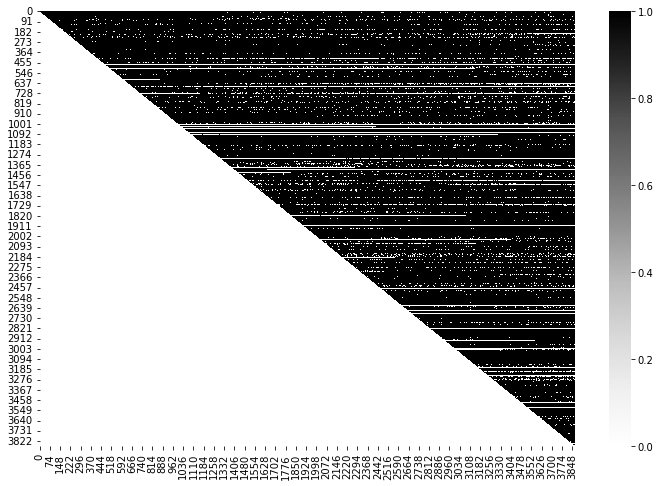

In [6]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.heatmap(node_batches_data["iter-0"]["coverage"]["recal"].T.cpu().numpy(), ax=ax, cmap="Greys")

In [ ]:
# mask_size = 50
# n_expr = 1000

# coverage_grid = node_batches_data["iter-0"]["coverage"]["recal"]
# selected_timesteps = (no_arrived > mask_size).nonzero(as_tuple=True)[0][torch.randperm((no_arrived > mask_size).sum())[:n_expr]]

In [ ]:
1 - cps["recal"].cp.return_possible_alpha(torch.linspace(0, 1, cal_mask.sum()), 1 - coverage_guarantee)

tensor(0.9008)

In [ ]:
edge_batches_data = {}
for cal_iter in range(15):
    print(f"Calibration : Iter = {cal_iter}")
    # allocating edge-dependent calibration
    cal_split = copy.deepcopy(main_split)
    cal_edge_index = cal_split.sample_edges(calibration_budget)
    cal_mask = (torch_geometric.utils.degree(cal_edge_index[0], num_nodes=dataset.x.shape[0]) > 0) & (~(labeled_mask))

    remaining_edges = cal_split._edge_budget.sum().item()
    n_batches = remaining_edges // (mini_batch_size)

    cps = {
        "no_recal": NonExchangeable(transformation_sequence, coverage_guarantee, "No-Recalibration"),
        "recal": Recalibrating(transformation_sequence, coverage_guarantee, "Recalibrating"),
        "weighted_recal": WeightedRecalibrating(transformation_sequence, coverage_guarantee, "WeightedRecal")
    }

    # initial step: calibration on subgraph
    cal_subgraph = GraphData(x=dataset.x, edge_index=union_edges(training_subgraph.edge_index, cal_edge_index), y=dataset.y)
    cal_logits = model.predict(cal_subgraph)
    for cp_key, cp in cps.items():
        cp.preprocess(cal_logits, cal_mask=cal_mask, overall_mask=(labeled_mask | cal_mask), y_mask=y_true_mask)


    timestep_split = copy.deepcopy(cal_split)

    test_arrived_edges = torch.tensor([[], []]).to(device).long()
    test_active_nodes = torch.zeros_like(cal_mask)

    timestep_records = []
    order_of_arrival = []

    for batch_i in range(n_batches):

        # computing step-subgraph
        torch.cuda.empty_cache()
        ts_edge_index = timestep_split.sample_edges(mini_batch_size)
        test_arrived_edges = union_edges(test_arrived_edges, ts_edge_index)
        step_edge_index = union_edges(cal_subgraph.edge_index, test_arrived_edges)
        step_subgraph = GraphData(x=dataset.x, edge_index=step_edge_index, y=dataset.y)
        # print(step_subgraph.edge_index.shape)
        step_logits = model.predict(step_subgraph)

        # computing corresponding node-index
        step_active_nodes_mask = utils.edges_to_node_mask(step_edge_index, n_vertices=dataset.x.shape[0])
        ts_node_mask = step_active_nodes_mask & ~(labeled_mask | cal_mask | test_active_nodes)

        for cp_key, cp in cps.items():
            cp.store_step(step_logtis, partial_mask=ts_node_mask, cal_mask=cal_mask, overall_mask=step_active_nodes_mask, y_mask=y_true_mask, graph=step_subgraph)

        timestep_records.append(test_active_nodes)
        order_of_arrival.append(ts_node_mask.nonzero(as_tuple=True)[0].clone())

        test_active_nodes = test_active_nodes | ts_node_mask


    timestep_records = torch.stack(timestep_records)
    appearance_idx = torch.concat(order_of_arrival)

    coverage_grids = {
        cp_key: cp.return_coverage_grid() for cp_key, cp in cps.items()
    }
    set_size_grids = {
        cp_key: cp.return_set_size_grid() for cp_key, cp in cps.items()
    }

    iter_result = {
        "appearance_idx": appearance_idx.cpu().clone(),
        "timestep_masks": timestep_records.cpu().clone(),
        "coverage":{
            cp_key: compute_cov_grid(coverage_grids[cp_key], timestep_records, appearance_idx).cpu().clone()
            for cp_key, cp in cps.items()
        },
        "set_size":{
            cp_key: compute_set_size_grid(set_size_grids[cp_key], timestep_records, appearance_idx).cpu().clone()
            for cp_key, cp in cps.items()
        },
        "coverage_grids": {cp_key: val.cpu().clone() for cp_key, val in coverage_grids.items()}
    }
    edge_batches_data[f"iter-{cal_iter}"] = iter_result

Calibration : Iter = 0


Calibration : Iter = 1
Calibration : Iter = 2
Calibration : Iter = 3
Calibration : Iter = 4
Calibration : Iter = 5
Calibration : Iter = 6
Calibration : Iter = 7
Calibration : Iter = 8
Calibration : Iter = 9


In [ ]:
coverage_grids_c = edge_batches_data["iter-0"]["coverage"]
coverage_grids = edge_batches_data["iter-0"]["coverage_grids"]
timestep_records = edge_batches_data["iter-0"]["timestep_masks"]
appearance_idx = edge_batches_data["iter-0"]["appearance_idx"]


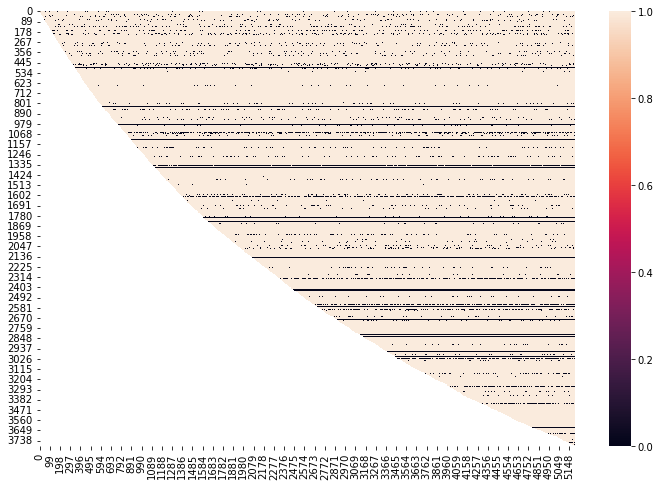

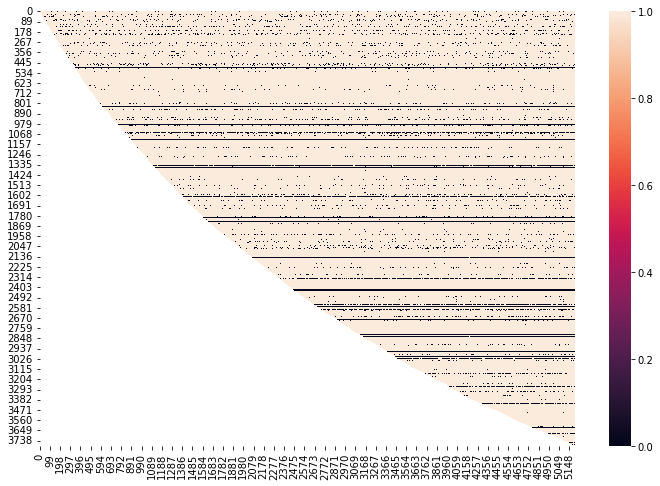

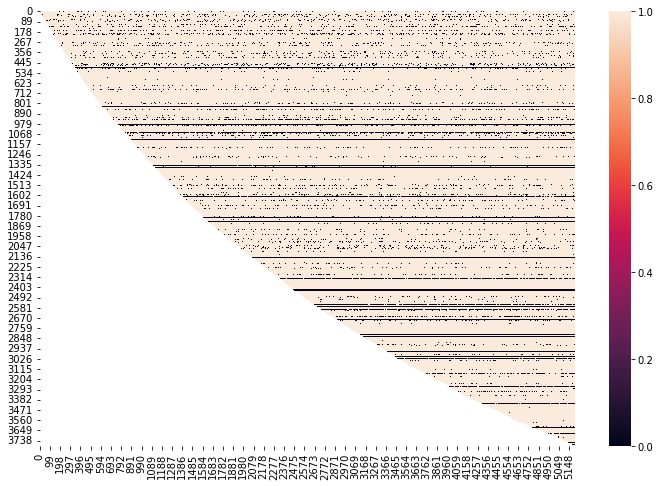

In [ ]:
cov_grid = coverage_grids_c["no_recal"]
f, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.heatmap(cov_grid.T.cpu().numpy(), ax=ax)
plt.show()
cov_grid = coverage_grids_c["recal"]
f, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.heatmap(cov_grid.T.cpu().numpy(), ax=ax)
plt.show()
cov_grid = coverage_grids_c["weighted_recal"]
f, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.heatmap(cov_grid.T.cpu().numpy(), ax=ax)
plt.show()

In [7]:
colorblind_codes = {
    "orange": "#f28e2b",
    "red": "#e15759",
    "green": "#59a14f",
    "blue": "#4e79a7"
}

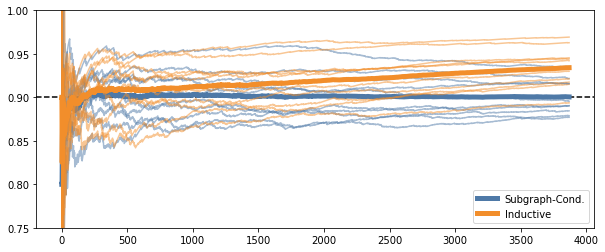

In [12]:
def upon_arrival_coverage(t_covers, t_mask):
    time_node_idxs = torch.concat([torch.tensor([0]), t_mask.sum(axis=1)])
    covs = []
    for i in range(time_node_idxs.shape[0] - 1):
        covs.append(t_covers[i, time_node_idxs[i]:time_node_idxs[i+1]])
    covs = torch.concat(covs)
    return covs

def plot_upon_arrival_coverages_node(key, color, ax, label):
    covs = torch.stack(
        [upon_arrival_coverage(node_experiment["coverage"][key], node_experiment["timestep_masks"]) 
        for it_idx, node_experiment in node_batches_data.items()])
    average_lines = covs.cumsum(axis=1) / (np.arange(covs.shape[1]) + 1)
    for i in range(average_lines.shape[0]):
        sns.lineplot(average_lines[i], color=color, ax=ax, alpha=0.5)
    main_ave_line = covs.mean(axis=0).cumsum(axis=0) / (np.arange(covs.shape[1]) + 1)
    sns.lineplot(main_ave_line, color=color, ax=ax, linewidth=5, label=label)

    return covs
    
f, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.axhline(0.9, color="black", linestyle="--", alpha=1)
ax.set_ylim(0.75, 1)

node_covs = {
    "recal": plot_upon_arrival_coverages_node("recal", colorblind_codes["blue"], ax, label="Subgraph-Cond."),
    "no_recal": plot_upon_arrival_coverages_node("no_recal", colorblind_codes["orange"], ax, label="Inductive"),
}


In [9]:
filename = f"./results_pth/plotables/diag-covs.pth"
torch.save(node_covs, filename)

In [34]:
key = "recal"
def node_set_size_sequence(key):
    result = []
    for iter_key in node_batches_data.keys():
        iter_set_size = node_batches_data[iter_key]["set_size"][key].diagonal()
        result.append((iter_set_size.cumsum(dim=0) / (torch.arange(iter_set_size.shape[0]) + 1)).cpu())
    result = torch.stack(result)
    return result

def node_singleton_hits_sequence(key):
    result = []
    for iter_key in node_batches_data.keys():
        iter_set_size = node_batches_data[iter_key]["set_size"][key].diagonal()
        iter_coverage = node_batches_data[iter_key]["coverage"][key].diagonal()

        result.append((((iter_set_size == 1) & (iter_coverage == 1)).float().cumsum(dim=0) / (torch.arange(iter_set_size.shape[0]) + 1)).cpu())
    result = torch.stack(result)
    return result


In [38]:
size_singleton_steps = {
    "set_size": {"recal": node_set_size_sequence("recal"), "no_recal": node_set_size_sequence("no_recal")},
    "singletons": {"recal": node_singleton_hits_sequence("recal"), "no_recal": node_singleton_hits_sequence("no_recal")},
}
filename = f"./results_pth/plotables/node-size-singleton-steps.pth"
torch.save(size_singleton_steps, filename)

In [49]:
sample_cov_grid =  node_batches_data["iter-0"]["coverage"]
sample_size_grid = node_batches_data["iter-0"]["set_size"]
sample_sh_grid = {key: (sample_cov_grid[key] == 1) & (sample_size_grid[key] == 1) for key in sample_cov_grid.keys()}

sample_stat_grid = {"coverage": sample_cov_grid, "set_size": sample_size_grid, "singletons": sample_sh_grid}
filename = f"./results_pth/plotables/sample_stat_grids.pth"
torch.save(sample_stat_grid, filename)

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False,  True]])

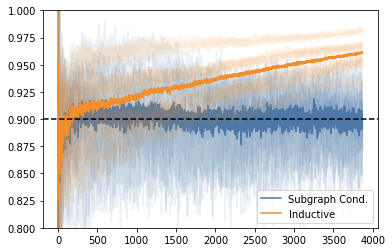

In [10]:
def plot_column_coverage_node(key, color, ax, label):
    res = []
    for iter, node_experiment in node_batches_data.items():
        cov = node_experiment["coverage"][key]
        time_dependent_cov = cov.nan_to_num(0).sum(axis=1) / ((~cov.isnan()).sum(axis=1))
        res.append(time_dependent_cov)
    min_res_len = np.min([(res_p).shape[0] for res_p in res])
    res_stacked = torch.stack([res_p[:min_res_len] for res_p in res])
    for res_line in res:
        sns.lineplot(res_line, color=color, ax=ax, alpha=0.1)
    resline = res_stacked.mean(axis=0)
    sns.lineplot(resline, ax=ax, color=color, label=label)
    return res_stacked

f, ax = plt.subplots(1, 1)
node_diags = {
    "recal": plot_column_coverage_node("recal", colorblind_codes["blue"], ax, "Subgraph Cond."),
    "no_recal": plot_column_coverage_node("no_recal", colorblind_codes["orange"], ax, "Inductive"),
}
ax.axhline(0.9, color="black", linestyle="--")
ax.set_ylim(0.8, 1)
filename = f"./results_pth/plotables/column-covs.pth"
torch.save(node_diags, filename)

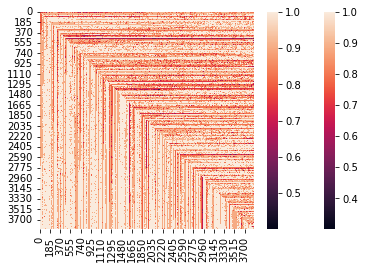

In [11]:
grid_means = {key: torch.stack([node_batches_data[f"iter-{i}"]["coverage"][key] for i in range(len(node_batches_data))]).mean(axis=0) for key, _ in node_batches_data[f"iter-{0}"]["coverage"].items()}

sns.heatmap(grid_means["recal"].T)
sns.heatmap(grid_means["no_recal"])

filename = f"./results_pth/plotables/grid_means.pth"
torch.save(grid_means, filename)

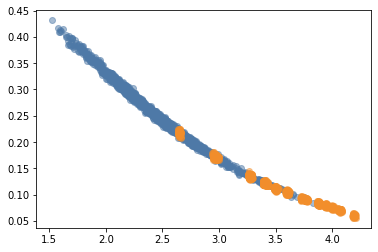

In [ ]:
scatter_plot_result = {}
for key in node_batches_data[f"iter-{0}"]["coverage"].keys():
    all_iter_points = []
    for iter_i in range(len(node_batches_data)):
        cov_grid = node_batches_data[f"iter-{iter_i}"]["coverage"][key]
        size_grid = node_batches_data[f"iter-{iter_i}"]["set_size"][key]

        column_covs = cov_grid.nan_to_num(0).sum(axis=1) / ((~cov_grid.isnan()).sum(axis=1))
        column_size = size_grid.sum(axis=1) / ((~cov_grid.isnan()).sum(axis=1))
        singleton_hit_indicator = (size_grid == 1) & (cov_grid == 1)
        columns_singleton_hits = singleton_hit_indicator.float().sum(axis=1) / ((~cov_grid.isnan()).sum(axis=1))
        points = torch.stack([column_covs, column_size, columns_singleton_hits])
        all_iter_points.append(points[:, -100:])
    all_iter_points = torch.concat(all_iter_points, dim=1).T
    scatter_plot_result[key] = all_iter_points.clone()

plt.scatter(scatter_plot_result["recal"][:, 1], scatter_plot_result["recal"][:, 2], color=colorblind_codes["blue"], alpha=0.5)
plt.scatter(scatter_plot_result["no_recal"][:, 1], scatter_plot_result["no_recal"][:, 2], color=colorblind_codes["orange"], alpha=0.5)

filename = f"./results_pth/plotables/size_singleton.pth"
torch.save(scatter_plot_result, filename)

In [ ]:
singleton_hits_dict = {}
for key in node_batches_data[f"iter-{0}"]["coverage"].keys():
    key_singleton_grid = []
    for iter_i in range(len(node_batches_data)):
        cov_grid = node_batches_data[f"iter-{iter_i}"]["coverage"][key]
        size_grid = node_batches_data[f"iter-{iter_i}"]["set_size"][key]

        singleton_hit_indicator = (size_grid == 1) & (cov_grid == 1)
        
        key_singleton_grid.append(singleton_hit_indicator)
    key_singleton_grid = torch.stack(key_singleton_grid)
    singleton_hits_dict[key] = key_singleton_grid.float().mean(axis=0).clone()

<AxesSubplot:>

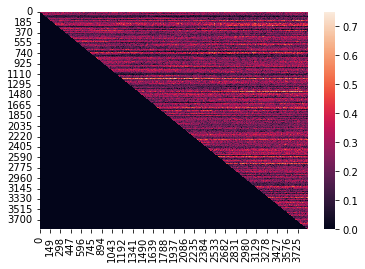

In [ ]:
sns.heatmap(singleton_hits_dict["recal"].T)

<AxesSubplot:>

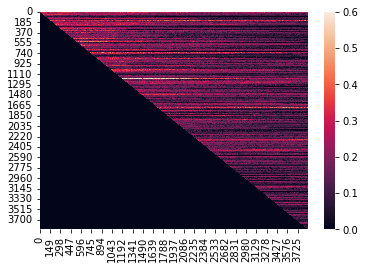

In [ ]:
sns.heatmap(singleton_hits_dict["no_recal"].T)

In [ ]:
filename = f"./results_pth/plotables/singleton_grid.pth"
torch.save(singleton_hits_dict, filename)

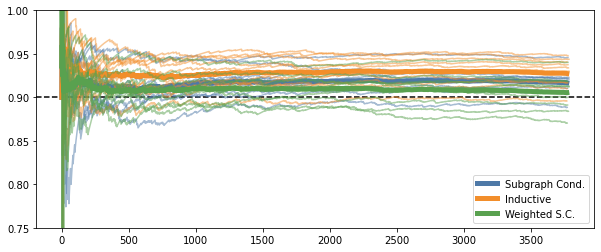

In [ ]:
def plot_upon_arrival_coverages_edge(key, color, ax, label):
    covs = [upon_arrival_coverage(edge_experiment["coverage"][key], edge_experiment["timestep_masks"]) 
            for it_idx, edge_experiment in edge_batches_data.items()]
    average_lines = [covs[i].cumsum(axis=0) / (np.arange(covs[i].shape[0]) + 1) for i in range(len(covs))]
    for i in range(len(average_lines)):
        sns.lineplot(average_lines[i], color=color, ax=ax, alpha=0.5)

    min_len = np.min([covs[i].shape[0] for i in range(len(covs))])
    cov_tensor_lines = torch.stack([covs[i][:min_len] for i in range(len(covs))])
    main_ave_line = cov_tensor_lines.mean(axis=0).cumsum(axis=0) / (np.arange(cov_tensor_lines.shape[1]) + 1)
    sns.lineplot(main_ave_line, color=color, ax=ax, linewidth=5, label=label)
    return covs
    
f, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.axhline(0.9, color="black", linestyle="--", alpha=1)
ax.set_ylim(0.75, 1)

edge_covs = {
    "recal": plot_upon_arrival_coverages_edge("recal", colorblind_codes["blue"], ax, label="Subgraph Cond."),
    "no_recal": plot_upon_arrival_coverages_edge("no_recal", colorblind_codes["orange"], ax, label="Inductive"),
    "weighted_recal": plot_upon_arrival_coverages_edge("weighted_recal", colorblind_codes["green"], ax, label="Weighted S.C."),
}


(0.8, 1.0)

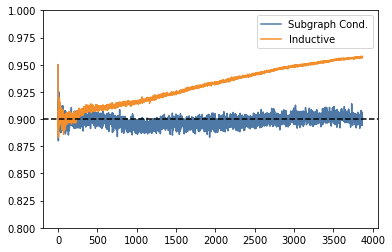

In [ ]:
def plot_column_coverage_node(key, color, ax, label):
    res = []
    for iter, node_experiment in node_batches_data.items():
        cov = node_experiment["coverage"][key]
        time_dependent_cov = cov.nan_to_num(0).sum(axis=1) / ((~cov.isnan()).sum(axis=1))
        res.append(time_dependent_cov)
    min_res_len = np.min([(res_p).shape[0] for res_p in res])
    res_stacked = torch.stack([res_p[:min_res_len] for res_p in res])
    # for res_line in res:
    #     sns.lineplot(res_line, color=color, ax=ax, alpha=0.5)
    resline = res_stacked.mean(axis=0)
    sns.lineplot(resline, ax=ax, color=color, label=label)
    return 

f, ax = plt.subplots(1, 1)
node_diags = {
    "recal": plot_column_coverage_node("recal", colorblind_codes["blue"], ax, "Subgraph Cond."),
    "no_recal": plot_column_coverage_node("no_recal", colorblind_codes["orange"], ax, "Inductive"),
}
ax.axhline(0.9, color="black", linestyle="--")
ax.set_ylim(0.8, 1)

(0.8, 1.0)

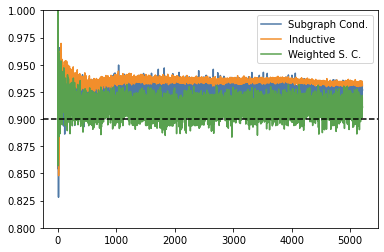

In [ ]:
def plot_column_coverage_edge(key, color, ax, label):
    res = []
    for iter, edge_experiment in edge_batches_data.items():
        cov = edge_experiment["coverage"][key]
        time_dependent_cov = cov.nan_to_num(0).sum(axis=1) / ((~cov.isnan()).sum(axis=1))
        res.append(time_dependent_cov)
    # min_res_len = np.min([(res_p).shape[0] for res_p in res])
    res_stacked = torch.stack([res_p for res_p in res])
    # for res_line in res[2:3]:
        # sns.lineplot(res_line, color=color, ax=ax)
    sns.lineplot(res_stacked[2:6,:].mean(axis=0), ax=ax, color=color, label=label)
    return res

f, ax = plt.subplots(1, 1)
plot_column_coverage_edge("recal", colorblind_codes["blue"], ax, "Subgraph Cond.")
plot_column_coverage_edge("no_recal", colorblind_codes["orange"], ax, "Inductive")
r = plot_column_coverage_edge("weighted_recal", colorblind_codes["green"], ax, "Weighted S. C.")
ax.axhline(0.9, color="black", linestyle="--")
ax.set_ylim(0.8, 1)

<AxesSubplot:ylabel='Density'>

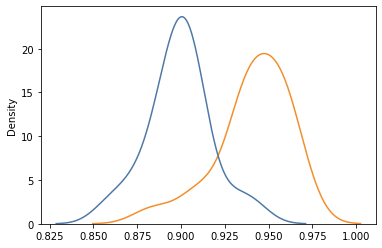

In [ ]:
grid = node_batches_data["iter-0"]["coverage"]["no_recal"].cpu()
masks = []
for i in range(100):
    random_mask = torch.zeros_like(grid).bool()
    random_mask[torch.arange(grid.shape[0]), torch.randperm(grid.shape[0])] = True
    random_mask[grid.isnan()] = False
    masks.append(random_mask.clone())

mask_coverages = {
    key:torch.stack([torch.stack([
        node_experiment["coverage"][key][random_mask].mean() 
        for iter_i, node_experiment in node_batches_data.items()
    ]) for random_mask in masks]) for key in ["no_recal", "recal"]
}
sns.kdeplot(mask_coverages["no_recal"].mean(axis=0), color=colorblind_codes["orange"])
sns.kdeplot(mask_coverages["recal"].mean(axis=0), color=colorblind_codes["blue"])


In [ ]:
result_dict = {
    "dataset": dataset_key,
    "model": model_key,
    "accuracy": acc,
    "diag_covs": {
        "node_exch": node_covs,
        "edge_exch": edge_covs
    },
    "sample_grid":{
        "node_exch": node_batches_data["iter-0"],
        "edge_exch": edge_batches_data["iter-0"]
    },
    "column_covs":{
        "node_exch": node_diags
    },
    "mask_coverages": {
        "node_exch": mask_coverages,
    }
}

In [ ]:
filename = f"./results_pth/{dataset_key}-{model_key}-{method}-batch{mini_batch_size}-summarised.pth"
torch.save(result_dict, filename)